<a href="https://colab.research.google.com/github/AxelADN/Mental_Rotations_Experiments/blob/main/Mental_Rotation_Exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!python --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00
Python 3.10.12


In [ ]:
import ipdb

In [ ]:
%pdb off

Automatic pdb calling has been turned OFF


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as pltPatch
from matplotlib import cm
from matplotlib.collections import PatchCollection
import numpy as np
from numpy import linspace
from math import sin, cos, tan, atan2, pi, sqrt, pow, acos
import csv
import time
import pandas as pd
from random import uniform
from scipy.stats import norm
#from copy import copy

# Bulk Random Polygon Generator

In [ ]:
class Point2D:

    #struct = {}
    p_uuid = 0
    DEFAULT_LIMITS = (
        (
            (-1,) , (1,)
        ),
        (
            (-1,) , (1,)
        )
    )

    def __init__(self,x0=None,y0=None,limits0=None):
        if limits0 == None:
            limits0 = Point2D.DEFAULT_LIMITS
        if x0 == None:
            xlim = limits0[0]
            lim_i=np.random.randint(len(xlim[0]))
            xR = xlim[1][lim_i]-xlim[0][lim_i]
            self.x = np.random.random()*xR+xlim[0][lim_i]
        else:
            self.x = x0
        if y0 == None:
            ylim = limits0[0]
            #lim_i=np.random.randint(len(xlim[0]))
            yR = ylim[1][lim_i]-ylim[0][lim_i]
            self.y = np.random.random()*yR+ylim[0][lim_i]
        else:
            self.y = y0
        self.magnitude = sqrt(pow(self.x,2)+pow(self.y,2))
        self.angle = atan2(self.y,self.x)
        if self.angle < 0:
            self.angle += 2*pi
        self.uid = "p0" + "." + str(Point2D.p_uuid) + "." + str(time.time_ns())
        Point2D.p_uuid += 1

    def coor(self):
        return (self.x,self.y)

    def reCoord(self,point0):
        self.x = point0.x
        self.y = point0.y

    def move(self,mag0,ang0):
        self.x += mag0*cos(ang0)
        self.y += mag0*sin(ang0)

    def __ne__(self,point0):
        return self.uid != point0.uid

    def __eq__(self, point0):
        return self.uid == point0.uid

    def __add__(self,point0):
        sumX = self.x + point0.x
        sumY = self.y + point0.y
        return Point2D(sumX,sumY)

    def __truediv__(self, val0):
        divX = self.x / val0
        divY = self.y / val0
        return Point2D(divX,divY)

    def __sub__(self, point0):
        return Point2D(self.x-point0.x,self.y-point0.y)

    def __mod__(self, val0):
        return Point2D(self.x%val0,self.y%val0)

    def __mul__(self,point0):
        return self.x*point0.x + self.y*point0.y

    def copy(self):
        newPoint = Point2D(self.x,self.y)
        return newPoint

    def getRawData(self):
        return (self.x,self.y)


    #def __iadd__(self,point0):
    #    if point0 != self:
    #        self.nextPoint = point0

    #def next(self):
    #  return self.nextPoint


In [ ]:

class Polygon2D:

    polygonClasses = []
    P_uuid = 0

    def __init__(self,vertices0=10,minAngle0=30,maxAngle0=150,maxPointShift0=.01,length0=.5,checks0=False,fingerPrint0="",limits0=()):
        #self.root = point0
        self.limits = limits0
        if len(self.limits) > 0:
            self.numLimits = len(self.limits[0][0])
        else:
            self.numLimits = 0
        self.center = Point2D(0.0,0.0)
        self.polygonClass = {}
        self.polyStruct = []
        self.polyStruct2 = []
        self.polyConvexHull = []
        self.pointList = []
        self.polygon2D = None
        self.checks=checks0
        self.length = length0
        self.vertices = vertices0
        self.maxAngle = maxAngle0*pi/180
        self.minAngle = minAngle0*pi/180
        self.maxPointShift = maxPointShift0
        self.uid = "P0" + "." + str(Polygon2D.P_uuid) + "." + str(time.time_ns())
        Polygon2D.P_uuid += 1
        self.polygonClass[self.uid] = None
        self.fingerPrinted = False
        if fingerPrint0 != "":
            self.polyStruct = [Point2D(x1,y1) for x1,y1 in eval(fingerPrint0)]
            self.fingerPrinted = True
        #Polygon2D.polygonClasses.append(self.polygonClass)

    def getFingerPrint(self):
        return str([(p.x,p.y) for p in self.polyStruct])

    def append(self,point0):
        self.polyStruct.append(point0)

    def insert(self, index0, point0):
        self.polyStruct.insert(index0, point0)

    def remove(self, point0):
        pointIndex = self.getPointIndex(point0)
        if pointIndex >= 0:
            self.polyStruct.pop(pointIndex)

    def insertNextTo(self, point0, point1):
        pointIndex = self.getPointIndex(point0)
        if pointIndex >= 0:
            self.polyStruct.insert(pointIndex, point1)

    def getPointIndex(self, point0):
        index_i = 0
        for point in self.polyStruct:
            if point == point0:
                return index_i
            index_i += 1
        return -1

    def getPoint(self, index0):
        return self.polyStruct[index0]

    def getAllPointsArray(self):
        pointsX = []
        pointsY = []
        for point in self.pointList:
            pointsX.append(point.x)
            pointsY.append(point.y)
        return pointsX,pointsY

    def rotate(self,angle0):
        rad = angle0*pi/180
        cx = 0
        cy = 0
        for p in self.polyStruct:
            cx += p.x
            cy += p.y
        cx /= len(self.polyStruct)
        cy /= len(self.polyStruct)
        for point in self.polyStruct:
            tx = point.x-cx
            ty = point.y-cy
            point.x = tx*cos(rad)+ty*sin(rad)+ cx
            point.y = (-1)*tx*sin(rad)+ty*cos(rad) + cy

    def copy(self):
        newPoly = Polygon2D()
        #newPoly.polygonClass = self.polygonClass
        newPoly.polyStruct = [x.copy() for x in self.polyStruct]
        newPoly.polyConvexHull = [x.copy() for x in self.polyConvexHull]
        newPoly.pointList = [x.copy() for x in self.pointList]
        newPoly.vertices = self.vertices
        newPoly.maxAngle = self.maxAngle
        newPoly.minAngle = self.minAngle
        newPoly.maxPointShift = self.maxPointShift
        return newPoly


    def mirror(self):
        for point in self.polyStruct:
            point.x = point.x*(-1)

    def getPolygonPatch(self):
        self.__generatePolygon()
        return self.polygon2D

    def buildPolygon(self):
        self.__generateAttneavePolygon()

    def __generatePolygon(self):
        pointArray = self.__getPointArray()
        self.polygon2D = pltPatch.Polygon(pointArray)

    def __getPointArray(self):
        xy = []
        for point in self.polyStruct:
            xy.append([point.x,point.y])
        return xy

    def getFamilyMember(self):
        newPoly = self.__buildFamilyMember()
        if self.polygonClass[self.uid] == None:
            self.polygonClass[self.uid] = self
            Polygon2D.polygonClasses.append(self.polygonClass)
        self.polygonClass[newPoly.uid] = newPoly
        newPoly.polygonClass = self.polygonClass
        return newPoly

    def __buildFamilyMember(self):
        intersectedPassed = False
        while not intersectedPassed:
            newPoly = self.copy()
            newPoly.__startPointShift()
            intersectedPassed = newPoly.__checkIntersections()
        return newPoly

    def __startPointShift(self):
        for point in self.polyStruct:
            point.move(np.random.random()*self.maxPointShift,np.random.random()*2*pi)

    def __generateAttneavePolygon(self):
        anglePassed = False
        if not self.fingerPrinted:
            while not anglePassed:
                self.polyStruct = []
                self.__generateRandomPoints()
                self.__getConvexHull()
                self.__startRandomPointInsertion()
                anglePassed = self.__startAngleCorrection()
                if self.checks and anglePassed:
                    anglePassed = self.__checkAngles()
                #anglePassed = True
            #self.move2Center()
        #self.__generatePolygon()

    def move2Center(self):
        if self.center.x == 0.0 and self.center.y == 0.0:
            xx = 0
            yy = 0
            for point in self.polyStruct:
                xx += point.x
                yy += point.y
            lenXY = len(self.polyStruct)
            self.center = Point2D(xx/lenXY,yy/lenXY)
        for point2move in self.polyStruct:
            point2move.reCoord(Point2D(self.center.x-point2move.x,self.center.y-point2move.y))

    def __checkAngles(self):
        for point0 in self.polyStruct:
            pointIndex0 = self.getPointIndex(point0)
            pointIndex1 = pointIndex0 - 1
            if pointIndex1 <= 0:
                pointIndex1 = len(self.polyStruct)-1
            pointIndex2 = pointIndex0 + 1
            if pointIndex2 >= len(self.polyStruct):
                pointIndex2 = 0
            p0 = point0
            p1 = self.polyStruct[pointIndex1]
            p2 = self.polyStruct[pointIndex2]
            v1 = p1 - p0
            v2 = p2 - p0
            t1 = v1.angle
            t2 = v2.angle
            tt = abs(t2-t1)
            if tt > pi:
                tt = 2*pi-tt
            if tt < self.minAngle or tt > self.maxAngle:
                print("tt: "+str(tt*180/pi))
                return False
        return True

    def __startAngleCorrection(self):
        point2Check = []
        point2Check2 = []
        for i in self.polyStruct:
            point2Check = []
            for point in self.polyStruct:
                angleCorrected = self.__correctAngle(point)
                if not angleCorrected:
                    point2Check.append(point)
            if len(point2Check) <= 0:
                return True
        if len(point2Check) > 0:
            print("ERROR --> Angle check did not pass! -- Angles: "+str(len(point2Check)))
            return False
        if False:
            len1 = len(point2Check)
            while len(point2Check) > 0:
                for point in point2Check:
                    angleCorrected = self.__correctAngle(point)
                    if not angleCorrected:
                        point2Check2.append(point)
                point2Check = [x for x in point2Check2]
                point2Check2 = []
                len1 -= 1
                if len1<=0:
                    if len(point2Check) > 0:
                        print("ERROR --> Angle check not passed! -- Angles: "+str(len(point2Check)))
                        return False
                    return True
        return True


    def __startRandomPointInsertion(self):
        otherPoints = []
        pointsTaken = []
        for point in self.pointList:
            if point not in self.polyConvexHull:
                otherPoints.append(point)
        self.polyStruct.extend(self.polyConvexHull)
        for otherPoint in otherPoints:
            intersectedFlag = False
            pointsTaken = [x for x in range(len(self.polyStruct))]
            while intersectedFlag == False:
                if len(pointsTaken) <= 0:
                    print("ERROR --> ALL SEGMENTS INTERSECTED?? -- ")
                    break
                pointIndex = pointsTaken.pop(np.random.randint(len(pointsTaken)))
                randomPolyPoint = self.polyStruct[pointIndex]
                self.insertNextTo(randomPolyPoint,otherPoint)
                intersectedFlag = self.__checkIntersections()
                if not intersectedFlag:
                    self.remove(otherPoint)

    def __checkLimGroup(self,point0):
        limx_ = self.limits[0][0]
        limx = self.limits[0][1]
        limy_ = self.limits[1][0]
        limy = self.limits[1][1]
        for lim_i in range(len(limx_)):
            if (point0.x <= limx[lim_i] and point0.x >= limx_[lim_i]) and (point0.y <= limy[lim_i] and point0.y >= limy_[lim_i]):
                print("("+str(point0.x)+","+str(point0.y))
                print("limx: ("+str(limx_[lim_i])+","+str(limx[lim_i])+") -- limy: ("+str(limy_[lim_i])+","+str(limy[lim_i])+")")
                print(lim_i)
                return lim_i

    def __checkAngleSum(self):
        angleSum = 0
        for point in self.polyStruct:
            index_m = self.getPointIndex(point)
            index_1 = index_m + 1
            if index_1 >= len(self.polyStruct):
                index_1 = len(self.polyStruct) - 1
            index_2 = index_m - 1
            if index_2 <= 0:
                index_2 = 0
            p0 = point
            p1 = self.polyStruct[index_1]
            p2 = self.polyStruct[index_2]
            v1 = p1 - p0
            v2 = p2 - p0
            m1 = v1.magnitude
            m2 = v2.magnitude
            angle = acos( (v1*v2) / (m1*m2) )
            angleSum += angle
        return angleSum/len(self.polyStruct)


    def __correctAngle(self,point0):
        pastPoint = point0.copy()
        pointIndex0 = self.getPointIndex(point0)
        pointIndex1 = pointIndex0 - 1
        if pointIndex1 <= 0:
            pointIndex1 = len(self.polyStruct)-1
        pointIndex2 = pointIndex0 + 1
        if pointIndex2 >= len(self.polyStruct):
            pointIndex2 = 0
        p0 = point0
        p1 = self.polyStruct[pointIndex1]
        p2 = self.polyStruct[pointIndex2]
        p_m = (p1+p2) / 2
        v_m = p_m - p0
        v1 = p1 - p0
        v2 = p2 - p0
        t_m = v_m.angle
        t1 = v1.angle
        t2 = v2.angle
        m_m = v_m.magnitude
        m1 = v1.magnitude
        m2 = v2.magnitude
        #tt = acos( (v1*v2) / (m1*m2) )
        tt = abs(t2-t1)
        if tt > pi:
            aux_tt =2*pi - tt
        else:
            aux_tt = tt
        if aux_tt <= self.minAngle:
            pastPoint = self.__moveMiddlePointStrategy(p0,p1,p2,tt,t1,t2)
        if aux_tt > self.maxAngle:
            self.__moveExtremePointsStrategy()
        if not self.__checkIntersections(True):
            point0.reCoord(pastPoint)
            return False
        else:
            #print("moved! --> "+str(pastPoint.coor())+" - "+str(point0.coor()))
            dp = (sqrt(pow(p_m.x-pastPoint.x,2)+pow(p_m.y-pastPoint.y,2)))-(sqrt(pow(p_m.x-point0.x,2)+pow(p_m.y-point0.y,2)))
            if dp < 0:
                 #ipdb.set_trace(context=6)
                 print("ERROR --> Point moved more than it should! -- Impossible??")
                 pass
        return True

    def __moveExtremePointsStrategy(self):
        pass

    def __moveMiddlePointStrategy(self,p0,p1,p2,tt,t1,t2, unique0=0):
        case = 0
        if unique0 > 0:
            _tt = unique0#(np.random.random()*(((self.maxAngle+self.minAngle)/2)-self.minAngle)+self.minAngle)
        else:
            _tt = (np.random.random()*(((self.maxAngle+self.minAngle)/2)-self.minAngle)+self.minAngle)
        if t2 > t1:
            if tt > pi:
                tt = 2*pi-tt
                _tt = 2*pi-_tt
                _t1 = t1 + (abs(_tt - tt) / 2)
                _t2 = t2 - (abs(_tt - tt) / 2)
            else:
                #print("ERROR --> t1: "+str(round(t1*180/pi,2))+" + tt: "+str(round(tt*180/pi,2))+", t2: "+str(round(t2*180/pi,2))+" -- Not Equal??")
                _t1 = t1 - (abs(_tt - tt) / 2)
                _t2 = t2 + (abs(_tt - tt) / 2)
        else:
            if tt > pi:
                tt = 2*pi-tt
                _tt = 2*pi-_tt
                _t1 = t1 - (abs(_tt - tt) / 2)
                _t2 = t2 + (abs(_tt - tt) / 2)
                #print("ERROR --> t2: "+str(round(t2*180/pi,2))+" + tt: "+str(round(tt*180/pi,2))+", t1: "+str(round(t1*180/pi,2))+" -- Not Equal??")
            else:
                _t1 = t1 + (abs(_tt - tt) / 2)
                _t2 = t2 - (abs(_tt - tt) / 2)
        _m1 = tan(_t1)
        _m2 = tan(_t2)
        a = np.array([[_m1,-1],[_m2,-1]])
        b = np.array([_m1*p1.x-p1.y,_m2*p2.x-p2.y])
        xy = np.linalg.solve(a,b)
        pastPoint = p0.copy()
        p0.reCoord(Point2D(xy.item(0),xy.item(1)))
        #print("tt2: "+str(abs(_t2-_t1)*180/pi)+" -- tt: "+str(tt*180/pi))
        return pastPoint

        if False:#tt < self.minAngle or tt > self.maxAngle:
            _tt = (np.random.random()*(self.maxAngle-self.minAngle)+self.minAngle)
            if t1 - t2 > 0:
                _t2 = t1 - abs(_tt-tt)
            else:
                _t2 = t2 + abs(_tt-tt)
            #newAngle = self.__checkAngleSum()
            #b2 = tt + t2
            #b1 = tt + t1
            #_t2 = b2 - _tt
            #_t1 = b1 - _tt
            #ipdb.set_trace(context=6)
            _v2 = Point2D(m2*cos(_t2),m2*sin(_t2))
            tt2 = arccos( (v1*_v2) / (m1*m2) )
            #_v1 = Point2D(m1*cos(_t1),m1*sin(_t1))
            dm0 = (v_m*v2) / cos(newAngle/2) * m2
            dv0 = v1 - Point2D(dm1*cos(t1),dm1*sin(t1))
            #newPoint = (p_m-dv1) % 1.0
            #_p1 = (_v1 + p0)# % 1.0
            _p2 = (_v2 + p0)# % 1.0
            #p1.reCoord(_p1)
            p2.reCoord(_p2)
            return False
        return True



    def __getConvexHullSegments(self):
        segments = []
        for p1 in self.polyConvexHull:
            next = self.getPointIndex(p1)+1
            if next >= len(self.polyConvexHull):
                next = 0
            p2 = self.polyConvexHull[next]
            segments.append((p1,p2))
        return segments

    def __checkIntersections(self,all=False):
        convexHullSegments = self.__getConvexHullSegments()
        for p1a in self.polyStruct:
            nextPointIndexA = self.getPointIndex(p1a) + 1
            if nextPointIndexA >= len(self.polyStruct):
                nextPointIndexA = 0
            p2a = self.polyStruct[nextPointIndexA]
            lineA = (p1a,p2a)
            if (not all) and (lineA in convexHullSegments):
                continue
            for p1b in self.polyStruct:
                nextPointIndexB = self.getPointIndex(p1b) + 1
                if nextPointIndexB >= len(self.polyStruct):
                    nextPointIndexB = 0
                p2b = self.polyStruct[nextPointIndexB]
                lineB = (p1b,p2b)
                if ((not all) and (lineB in convexHullSegments)) or (lineA[0] == lineB[0] and lineA[1] == lineB[1]) or self.__shareVertex(lineA,lineB):
                    continue
                if self.__isIntersected(lineA,lineB):
                    return False
        return True

    def __shareVertex(self,lineA0, lineB0):
        return lineA0[0] == lineB0[0] or lineA0[0] == lineB0[1] or lineA0[1] == lineB0[0] or lineA0[1] == lineB0[1]

    def __isIntersected(self,lineA0, lineB0):
        p1 = lineA0[0]
        q1 = lineA0[1]
        p2 = lineB0[0]
        q2 = lineB0[1]
        o1 = self.__getOrientation(p1,q1,p2)
        o2 = self.__getOrientation(p1,q1,q2)
        o3 = self.__getOrientation(p2,q2,p1)
        o4 = self.__getOrientation(p2,q2,q1)
        if ((o1 != o2) and (o3 != o4)):
            return True
        if ((o1 == 0) and self.__onSegment(p1, p2, q1)):
            return True
        if ((o2 == 0) and self.__onSegment(p1, q2, q1)):
            return True
        if ((o3 == 0) and self.__onSegment(p2, p1, q2)):
            return True
        if ((o4 == 0) and self.__onSegment(p2, q1, q2)):
            return True
        return False

    def __generateRandomPoints(self):
        self.pointList = []
        range0 = .2
        xlim = (-.5,.5)
        ylim = (.5,-.5)
        x = 0.0
        y = 0.0
        if False:
            xy1 = [0.0,0.0]
            xy2 = [0.0,0.0]
            connected1 = (False,False)
            connected2 = (False,False)
            x = uniform(xlim[0]-range0,xlim[0]+range0)
            y = uniform(ylim[0]-range0,ylim[0]+range0)
            print([x,y])
            self.pointList.append(Point2D(x,y))
            x = uniform(xlim[1]-range0,xlim[1]+range0)
            y = uniform(ylim[1]-range0,ylim[1]+range0)
            self.pointList.append(Point2D(x,y))
            for i in range(self.vertices):
                x = uniform(-1,1)
                y = uniform(-1,1)
                while ((x < xlim[0]) and (y > ylim[0])) or ((x > xlim[1]) and (y < ylim[1])):
                    x = uniform(-1,1)
                    y = uniform(-1,1)
                self.pointList.append(Point2D(x,y))
        if len(self.limits) <= 0:
            for i in range(self.vertices):
                self.pointList.append(Point2D())
        else:
            for i in range(self.vertices):
                self.pointList.append(Point2D(limits0=self.limits))

    def __getConvexHull(self):
        self.polyConvexHull = []
        n = len(self.pointList)
        #print("points = "+str(n))
        OPoint = self.__getLeftMinimum()
        hull = []
        p = OPoint
        q = 0
        while(True):
            hull.append(p)
            q = (p+1)%n
            for i in range(n):
                if self.__getOrientation(self.pointList[p],self.pointList[i],self.pointList[q]) == 2:
                    q = i
                if p!=i and self.__getOrientation(self.pointList[p],self.pointList[i],self.pointList[q]) == 0 and self.__onSegment(self.pointList[p],self.pointList[i],self.pointList[q]):
                    q = i
            p = q
            if (p == OPoint):
                break
        for k in hull:
            self.polyConvexHull.append(self.pointList[k])
            #print(self.pointList[k])

    def __onSegment(self,p,q,r):
        return (q.x <= max(p.x,r.x) and q.x >= min(p.x,r.x)) and (q.y <= max(p.y,r.y) and q.y >= min(p.y,r.y))

    def __getOrientation(self,p,q,r):
        val = ((q.y-p.y)*(r.x-q.x))-((q.x-p.x)*(r.y-q.y))
        if val == 0: return 0
        elif val > 0: return 1
        else: return 2

    def __getLeftMinimum(self):
        lmin = 0
        for i in range(1,len(self.pointList)):
            if self.pointList[i].x < self.pointList[lmin].x:
                lmin = i
            elif self.pointList[i].x == self.pointList[lmin].x:
                if self.pointList[i].y > self.pointList[lmin].y:
                    lmin = i
        return lmin


In [ ]:
class BbPolygon2D(Polygon2D):

    def __init__(self,width0=.30,height0 = 1.50,origin0=(0,0),center0=Point2D(0.0,0.0)):
        Polygon2D.__init__(self)
        self.width = width0/2
        self.height = height0/2
        self.radius = width0
        self.origin = origin0
        self.center = center0
        self.__buildBbPolygon()
        #super().move2Center()
        pass

    def setCenter(self,center0):
        self.center = center0
        super().move2Center()


    def __buildBbPolygon(self):
        if False:
            p1 = Point2D(-self.width,self.height)
            p2 = Point2D(self.width,self.height)
            p3 = Point2D(self.width,-self.height)
            p4 = Point2D(-self.width,-self.height)
            self.polyStruct = [p1,p2,p3,p4]
        elif False:
            xx = [t for t in range(0,360,10)]
            xx = [tt*pi/180 for tt in xx]
            print(xx)
            x = []
            y = []
            for x_i in range(len(xx)):
                x.append(cos(xx[x_i])*self.radius+self.origin[0])
                y.append(sin(xx[x_i])*self.radius+self.origin[1])
            for x_k in range(len(x)):
                self.polyStruct.append(Point2D(x[x_k],y[x_k]))

        else:
            p1 = Point2D(-1,1)
            p2 = Point2D(-.75,.85)
            p3 = Point2D(.75,.85)
            p4 = Point2D(1,1)
            p5 = Point2D(.85,.75)
            p6 = Point2D(.85,-.75)
            p7 = Point2D(1,-1)
            p8 = Point2D(.75,-.85)
            p9 = Point2D(-.75,-.85)
            p10 = Point2D(-1,-1)
            p11 = Point2D(-.85,-.75)
            p12 = Point2D(-.85,.75)
            self.polyStruct = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]


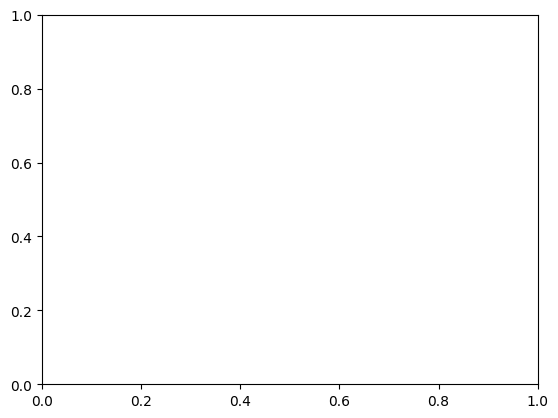

In [ ]:
polySet = []
polyLim = (
    (
        (-.7,) , (.7,)
    ),
    (
        (-.7,) , (.7,)
    )
)
lim=1.5
fig,ax = plt.subplots()
prefix = "Test_Data"

#hatch = ["o","xx", "/","*",".","x+","O","||","O.","\|"]

n = 10
f = 10
polypolySet = {}

polySet = []
families = []
for i in range(n+1):
    currentPoly = Polygon2D(vertices0=16,minAngle0=15,maxAngle0=165,limits0=polyLim,maxPointShift0=0.15)
    currentPoly.buildPolygon()

    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    plt.axis("off")
    original = currentPoly.getPolygonPatch()
    original.set_fc("black")
    original.set_alpha(1)
    ax.add_patch(original)
    plt.savefig(prefix+"/"+str(i)+"_O")
    ax.clear()
    for j in range(f):
        plt.xlim(-lim,lim)
        plt.ylim(-lim,lim)
        plt.axis("off")
        familiar = currentPoly.getFamilyMember()
        #familiar.buildPolygon()
        toPrint = familiar.getPolygonPatch()
        toPrint.set_fc("black")
        toPrint.set_alpha(1)
        ax.add_patch(toPrint)
        plt.savefig(prefix+"/"+str(i)+"_F"+str(j))
        ax.clear()
    #polySet.append(currentPoly)
#polypolySet[t] = polySet


In [ ]:
!zip -r /content/Test_Data.zip /content/Test_Data
from google.colab import files
files.download("/content/Test_Data.zip")

  adding: content/Test_Data/ (stored 0%)
  adding: content/Test_Data/10_F0.png (deflated 23%)
  adding: content/Test_Data/8_F9.png (deflated 22%)
  adding: content/Test_Data/9_F8.png (deflated 24%)
  adding: content/Test_Data/10_F6.png (deflated 21%)
  adding: content/Test_Data/5_F2.png (deflated 25%)
  adding: content/Test_Data/3_F4.png (deflated 25%)
  adding: content/Test_Data/10_F5.png (deflated 21%)
  adding: content/Test_Data/10_F8.png (deflated 22%)
  adding: content/Test_Data/1_F9.png (deflated 25%)
  adding: content/Test_Data/8_F8.png (deflated 21%)
  adding: content/Test_Data/3_F2.png (deflated 25%)
  adding: content/Test_Data/6_F5.png (deflated 24%)
  adding: content/Test_Data/9_F6.png (deflated 24%)
  adding: content/Test_Data/5_F9.png (deflated 25%)
  adding: content/Test_Data/10_F3.png (deflated 23%)
  adding: content/Test_Data/9_F7.png (deflated 25%)
  adding: content/Test_Data/7_F6.png (deflated 23%)
  adding: content/Test_Data/7_F4.png (deflated 23%)
  adding: content/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -rf Test_Data/
!mkdir Test_Data

FileNotFoundError: ignored

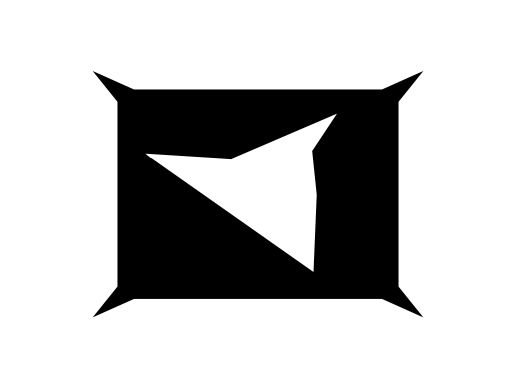

In [ ]:
polySet = []
polyLim = (
    (
        (-.7,) , (.7,)
    ),
    (
        (-.7,) , (.7,)
    )
)
lim=1.5
fig,ax = plt.subplots()
prefix = "Test_Data"
prefixs = {"T":prefix+"/","Ex":prefix+"_Ex/","PR":prefix+"_PR/","PO":prefix+"_PO/"}
#hatch = ["o","xx", "/","*",".","x+","O","||","O.","\|"]
orientations = [str(x) for x in range(0,181,20)]
blocks = [30,30,10,30]
polyBlocks = {"T":10,"Ex":30,"PO":30,"PR":30}
polypolySet = {}

for t,n in polyBlocks.items():
    polySet = []

    for i in range(n+1):
        currentPoly = Polygon2D(vertices0=8,minAngle0=1,maxAngle0=179,limits0=polyLim)
        currentPoly.buildPolygon()
        bBPoly10 = BbPolygon2D()
        currentDict = {}

        plt.xlim(-lim,lim)
        plt.ylim(-lim,lim)
        plt.axis("off")
        original = currentPoly.getPolygonPatch()
        original.set_fc("white")
        original.set_alpha(1)
        bBPatch = bBPoly10.getPolygonPatch()
        bBPatch.set_fc("black")
        bBPatch.set_alpha(1)
        ax.add_patch(bBPatch)
        ax.add_patch(original)
        plt.savefig(prefixs[t]+"S"+str(i)+"_O")
        ax.clear()
        polySet.append(currentPoly)
    polypolySet[t] = polySet





In [ ]:
def convert2Semicolon(data0):
    dataSemicolon = ""
    for dat in data0:
        dataSemicolon += str(dat)+";"
    return [dataSemicolon]

for t,n in polyBlocks.items():

    orientations = [str(x) for x in range(0,181,20)]
    sampleFile = open(prefixs[t]+"Test_Data.csv","w")
    writer = csv.writer(sampleFile)
    header = ["Index","UUID","Original"]
    header.extend(["R"+str(x) for x in range(len(orientations))])
    header.append("constantRot")
    print(convert2Semicolon(header))
    writer.writerow(convert2Semicolon(header))
    numPoly = 0
    i = 0
    polySet = polypolySet[t]
    for polyD in polySet:
        currentUUID = polyD.uid
        data = [numPoly,currentUUID,prefix+"S"+str(numPoly)+"_O.png"]
        for or_i in range(len(orientations)):
            data.append(orientations[(i+or_i)%len(orientations)])
        header.append("60")
        writer.writerow(convert2Semicolon(data))
        numPoly += 1
        i += 1
        if i >= len(orientations):
            i = 0
    sampleFile.close()

['Index;UUID;Original;R0;R1;R2;R3;R4;R5;R6;R7;R8;R9;constantRot;']
['Index;UUID;Original;R0;R1;R2;R3;R4;R5;R6;R7;R8;R9;constantRot;']
['Index;UUID;Original;R0;R1;R2;R3;R4;R5;R6;R7;R8;R9;constantRot;']
['Index;UUID;Original;R0;R1;R2;R3;R4;R5;R6;R7;R8;R9;constantRot;']


In [ ]:
!zip -r /content/Test_Data.zip /content/Test_Data /content/Test_Data_Ex/ /content/Test_Data_PO/ /content/Test_Data_PR/
from google.colab import files
files.download("/content/Test_Data.zip")

In [ ]:
files.download("/content/Test_Data/Test_Data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

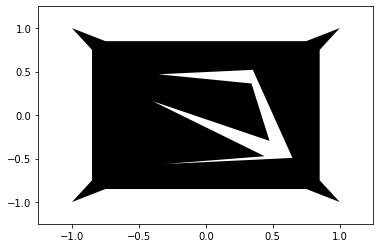

In [ ]:
lim=1.25
patches = []
polyLim = (
    (
        (-.7,) , (.7,)
    ),
    (
        (-.7,) , (.7,)
    )
)
polygon = Polygon2D(vertices0=8,minAngle0=1,maxAngle0=179,checks0=True,limits0=polyLim)
polygon.buildPolygon()
polygon2 = BbPolygon2D()
#polygon2 = BbPolygon2D(origin0=(-.5,.5),center0=polygon.center)
#polygon3 = BbPolygon2D(origin0=(.5,-.5),center0=polygon.center)
fig,ax = plt.subplots()
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
#plt.axis("off")
poly1 = polygon.getPolygonPatch()
poly1.set_fc("white")
poly1.set_alpha(1)
#plt.savefig("prueba.png")
#ax.clear()
#plt.close()
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
#plt.axis("off")
poly2 = polygon2.getPolygonPatch()
#poly2 = pltPatch.Circle((0,0),1,fill=False,hatch="/o")
#poly2.set(fill=False)
poly2.set_alpha(1)
#poly2.set(linewidth=3)
poly2.set_fc("black")
#poly3 = polygon3.getPolygonPatch()
#poly3.set(fill=False)
#poly3.set_alpha(1)
#poly3.set(linewidth=3)
#poly3.set_fc("red")
ax.add_patch(poly2)
ax.add_patch(poly1)
#ax.add_patch(poly3)
plt.draw()
plt.savefig("prueba2.png")
#plt.close()
#print(len(points))




---


# Experiment

In [ ]:
class MT_Data():

    MIRROR = "Mirrored"
    KEYS = "key_resp.keys"
    INDEX = "Index"
    RT = "key_resp.rt"
    PR = "PR_"
    PO = "PO_"
    ROTATION = "Rotation"
    PREFIX_NAME = "Results/"
    UUID = "UUID"
    BLOCK = "initTrial"

    ANGLE_STEP = 20
    ANGLE_START = 0
    ANGLE_STOP = 180

    totalNumExp = 0

    def __init__(self,data_name0="",cutoff_PR0=0,cutoff_PO0=0,normal0=True,PR=True, PO=True, Tr=True,includeMirrored0=True,includeIncorrects0=True ,prefix="",plot=False):
        #MT_Data.KEYS = prefix+MT_Data.KEYS
        self.cutoff_PR = cutoff_PR0
        self.cutoff_PO = cutoff_PO0
        self.includeMirrored = includeMirrored0
        self.includeIncorrects = includeIncorrects0
        MT_Data.RT = prefix+MT_Data.RT
        self.normal = normal0
        self.data_name = data_name0
        self.data_mirror = None
        self.data_mirror_i = None
        self.data_respons_Tr = None
        self.data_respons_Tr_i = None
        self.data_respons_PR = None
        self.data_respons_PR_i = None
        self.data_respons_PO = None
        self.data_respons_PO_i = None
        #self.numTrials = 0
        self.data_RT_Tr = None
        self.data_RT_Tr_i = None
        self.data_RT_PR = None
        self.data_RT_PR_i = None
        self.data_RT_PO = None
        self.data_RT_PO_i = None
        self.data_rotation = None
        self.data_rotation_i = None
        self.data_block = None
        self.data_block_i = None
        self.numExp = MT_Data.totalNumExp
        self.totalAccuracy_Tr = 0
        self.totalAccuracy_PR = 0
        self.totalAccuracy_PO = 0
        self.responsesList_Tr = {}
        self.responsesList_PR = {}
        self.responsesList_PO = {}
        self.accPerBlock_Tr = {r:0 for r in range(0,1000,100)}
        self.accPerRotation_PR = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        self.accPerRotation_PO = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        self.numCorrectPerBlock_Tr = {r:0 for r in range(0,1000,100)}
        self.numCorrectPerRotation_PR = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        self.numCorrectPerRotation_PO = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        self.rtPerBlock_Tr = {r:0 for r in range(0,1000,100)}
        self.rtPerRotation_PR = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        self.rtPerRotation_PO = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        self.numRtPerBlock_Tr = {r:0 for r in range(0,1000,100)}
        self.numRtPerRotation_PR = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        self.numRtPerRotation_PO = {r:0 for r in range(MT_Data.ANGLE_START,MT_Data.ANGLE_STOP+1,MT_Data.ANGLE_STEP)}
        MT_Data.totalNumExp += 1
        self.numTr = 0
        self.numPR = 0
        self.numPO = 0

        if plot:
            self.fig, axs = plt.subplots(4,3,figsize=(12, 8))
        df = pd.read_csv(MT_Data.PREFIX_NAME+self.data_name)
        self.__extractData_General(df)

        self.__extractData_PR(df)
        self.__getTotalAccuracy_PR()
        self.__getTrialResponse_PR()
        self.__getRotationAcc_PR()
        self.__getRotationRT_PR()
        self.__getNormalRT_PR()
        if plot:
            self.axRT_PR = axs[0][0]
            self.axAcc_PR = axs[0][1]
            self.axRT_PR_Normal = axs[0][2]
            self.__makePlot_PR()

        if PR:
            self.__extractData_PO(df)
            self.__getTotalAccuracy_PO()
            self.__getTrialResponse_PO()
            self.__getRotationAcc_PO()
            self.__getRotationRT_PO()
            self.__getNormalRT_PO()
            if plot:
                self.axRT_PO = axs[1][0]
                self.axAcc_PO = axs[1][1]
                self.axRT_PO_Normal = axs[1][2]
                self.__makePlot_PO()

        if Tr:
            self.__extractData_Tr(df)
            #self.__getTotalAccuracy_Tr()
            self.__getTrialResponse_Tr()
            self.__getBlockAcc_Tr()
            self.__getBlockRT_Tr()
            if plot:
                self.axRT_Tr = axs[3][0]
                self.axAcc_Tr = axs[3][1]
                self.__makePlot_Tr()

        if PO and PR:
            if plot:
                self.axRT_Diff = axs[2][0]
                self.axAcc_Diff = axs[2][1]
                self.__makePlot_Diff()

        self.fig.tight_layout(pad=1.0)

    def getData(self):
        return [self.__getPRData(),self.__getPOData(),self.__getDiffData(),self.__getTrData()]

    def __getNormalRT_PR(self):
        data = self.data_RT_PR.to_numpy()
        self.rtNormal_PR = self.__normal_dist(data,self.mean_PR,self.sd_PR)

    def __getNormalRT_PO(self):
        data = self.data_RT_PO.to_numpy()
        self.rtNormal_PO = self.__normal_dist(data,self.mean_PO,self.sd_PO)


    def __getDiffData(self):
        rtPerRotation_Diff = {r1:(po-pr) for (r1,po),(r2,pr) in zip(self.rtPerRotation_PO.items(),self.rtPerRotation_PR.items())}
        accPerRotation_Diff = {r1:(po-pr) for (r1,po),(r2,pr) in zip(self.accPerRotation_PO.items(),self.accPerRotation_PR.items())}
        rtPerRotation_Diff = self.__normalize(rtPerRotation_Diff)
        rtPerRotation_Diff = {r:-d for r,d in rtPerRotation_Diff.items()}
        accPerRotation_Diff = self.__normalize(accPerRotation_Diff)
        llsqRT_x,llsqRT_y = self.__LLSQ(rtPerRotation_Diff)
        llsqAcc_x,llsqAcc_y = self.__LLSQ(accPerRotation_Diff)
        return [rtPerRotation_Diff.items(),accPerRotation_Diff.items(),llsqRT_x,llsqRT_y,llsqAcc_x,llsqAcc_y]

    def __getPRData(self):
        llsqRT_x,llsqRT_y = self.__LLSQ(self.rtPerRotation_PR)
        llsqAcc_x,llsqAcc_y = self.__LLSQ(self.accPerRotation_PR)
        self.rtPerRotation_PR = self.__normalize(self.rtPerRotation_PR)
        self.accPerRotation_PR = self.__normalize(self.accPerRotation_PR)
        llsqRT_y = self.__normalizeNP(llsqRT_y)
        llsqAcc_y = self.__normalizeNP(llsqAcc_y)
        return [self.rtPerRotation_PR.items(),self.accPerRotation_PR.items(),llsqRT_x,llsqRT_y,llsqAcc_x,llsqAcc_y]

    def __getPOData(self):
        llsqRT_x,llsqRT_y = self.__LLSQ(self.rtPerRotation_PO)
        llsqAcc_x,llsqAcc_y = self.__LLSQ(self.accPerRotation_PO)
        self.rtPerRotation_PO = self.__normalize(self.rtPerRotation_PO)
        self.accPerRotation_PO = self.__normalize(self.accPerRotation_PO)
        llsqRT_y = self.__normalizeNP(llsqRT_y)
        llsqAcc_y = self.__normalizeNP(llsqAcc_y)
        return [self.rtPerRotation_PO.items(),self.accPerRotation_PO.items(),llsqRT_x,llsqRT_y,llsqAcc_x,llsqAcc_y]

    def __getTrData(self):
        llsqRT_x,llsqRT_y = self.__LLSQ(self.rtPerBlock_Tr)
        llsqAcc_x,llsqAcc_y = self.__LLSQ(self.accPerBlock_Tr)
        self.rtPerBlock_Tr = self.__normalize(self.rtPerBlock_Tr)
        self.accPerBlock_Tr = self.__normalize(self.accPerBlock_Tr)
        llsqRT_y = self.__normalizeNP(llsqRT_y)
        llsqAcc_y = self.__normalizeNP(llsqAcc_y)
        return [self.rtPerBlock_Tr.items(),self.accPerBlock_Tr.items(),llsqRT_x,llsqRT_y,llsqAcc_x,llsqAcc_y]

    def __makePlot_Diff(self):
        data = self.__getDiffData()
        self.axRT_Diff.plot(*zip(*sorted(data[0])),"-o",color="r")
        self.axAcc_Diff.plot(*zip(*sorted(data[1])),"-o",color="r")
        self.axAcc_Diff.plot(data[4],data[5],color="b")
        self.axRT_Diff.plot(data[2],data[3],color="b")

    def __makePlot_Tr(self):

        data = self.__getTrData()
        self.axRT_Tr.plot(*zip(*sorted(data[0])),"-o",color="r")
        self.axAcc_Tr.plot(*zip(*sorted(data[1])),"-o",color="r")
        self.axAcc_Tr.plot(data[4],data[5],color="b")
        self.axRT_Tr.plot(data[2],data[3],color="b")

    def __makePlot_PO(self):

        data = self.__getPOData()
        self.axRT_PO.plot(*zip(*sorted(data[0])),"-o",color="r")
        self.axAcc_PO.plot(*zip(*sorted(data[1])),"-o",color="r")
        self.axAcc_PO.plot(data[4],data[5],color="b")
        self.axRT_PO.plot(data[2],data[3],color="b")
        normalData = [(x,y) for x,y in zip(self.data_RT_PO.to_numpy(),self.rtNormal_PO.tolist())]
        self.axRT_PO_Normal.plot(*zip(*normalData),".",color="red")
        self.axRT_PO_Normal.axvline(x=self.mean_PO)
        self.axRT_PO_Normal.axvline(x=self.mean_PO-self.cutoff_PO)
        self.axRT_PO_Normal.axvline(x=self.mean_PO+self.cutoff_PO)

    def __makePlot_PR(self):

        data = self.__getPRData()
        self.axRT_PR.plot(*zip(*sorted(data[0])),"-o",color="r")
        self.axAcc_PR.plot(*zip(*sorted(data[1])),"-o",color="r")
        self.axAcc_PR.plot(data[4],data[5],color="b")
        self.axRT_PR.plot(data[2],data[3],color="b")
        normalData = [(x,y) for x,y in zip(self.data_RT_PR,self.rtNormal_PR.tolist())]
        self.axRT_PR_Normal.plot(*zip(*normalData),".",color="red")
        self.axRT_PR_Normal.axvline(x=self.mean_PR)
        self.axRT_PR_Normal.axvline(x=self.mean_PR)
        self.axRT_PR_Normal.axvline(x=self.mean_PR-self.cutoff_PR)
        self.axRT_PR_Normal.axvline(x=self.mean_PR+self.cutoff_PR)

    def plot(self):
        plt.figure(self.fig.number)
        plt.show()

    def __extractData_General(self,df):
        self.data_uid = df[pd.notnull(df[MT_Data.UUID])][MT_Data.UUID]
        self.data_uid_i = self.data_uid.index
        self.data_mirror = df[pd.notnull(df[MT_Data.MIRROR])][MT_Data.MIRROR]
        self.data_mirror_i = self.data_mirror.index
        self.data_rotation = df[pd.notnull(df[MT_Data.ROTATION])][MT_Data.ROTATION]
        self.data_rotation_i = self.data_rotation.index

    def __extractData_Tr(self,df):
        self.data_respons_Tr = df[pd.notnull(df[MT_Data.KEYS])][MT_Data.KEYS]
        self.data_respons_Tr_i = self.data_respons_Tr.index
        self.data_RT_Tr = df[pd.notnull(df[MT_Data.RT])][MT_Data.RT]
        self.data_RT_Tr_i = self.data_RT_Tr.index
        self.numTr = len(self.data_respons_Tr_i)
        self.data_block = df[pd.notnull(df[MT_Data.BLOCK])][MT_Data.BLOCK]
        self.data_block_i = self.data_block.index

    def __extractData_PR(self,df):
        data = df[pd.notnull(df[MT_Data.PR+MT_Data.RT])][MT_Data.PR+MT_Data.RT].to_numpy()
        self.mean_PR = np.mean(data)
        self.sd_PR = np.std(data)
        if self.cutoff_PR <= 0:
            self.cutoff_PR = self.mean_PR-np.amin(data)
            print("PR: "+str(self.cutoff_PR))
            print(" m: "+str(self.mean_PR))
        self.data_respons_PR = df[pd.notnull(df[MT_Data.PR+MT_Data.KEYS])][MT_Data.PR+MT_Data.KEYS]
        self.data_respons_PR = self.data_respons_PR[df[MT_Data.PR+MT_Data.RT]<self.mean_PR+self.cutoff_PR]
        self.data_respons_PR = self.data_respons_PR[df[MT_Data.PR+MT_Data.RT]>self.mean_PR-self.cutoff_PR]
        self.data_respons_PR_i = self.data_respons_PR.index
        self.data_RT_PR = df[pd.notnull(df[MT_Data.PR+MT_Data.RT])][MT_Data.PR+MT_Data.RT]
        self.data_RT_PR = self.data_RT_PR[df[MT_Data.PR+MT_Data.RT]<self.mean_PR+self.cutoff_PR]
        self.data_RT_PR = self.data_RT_PR[df[MT_Data.PR+MT_Data.RT]>self.mean_PR-self.cutoff_PR]
        self.data_RT_PR_i = self.data_RT_PR.index
        self.numPR = len(self.data_respons_PR_i)


    def __extractData_PO(self,df):
        data = df[pd.notnull(df[MT_Data.PO+MT_Data.RT])][MT_Data.PO+MT_Data.RT].to_numpy()
        self.mean_PO = np.mean(data)
        self.sd_PO = np.std(data)
        if self.cutoff_PO <= 0:
            self.cutoff_PO = self.mean_PO - np.amin(data)
            print("PO: "+str(self.cutoff_PO))
            print(" m: "+str(self.mean_PO))
        self.data_respons_PO = df[pd.notnull(df[MT_Data.PO+MT_Data.KEYS])][MT_Data.PO+MT_Data.KEYS]
        self.data_respons_PO = self.data_respons_PO[df[MT_Data.PO+MT_Data.RT]<self.mean_PO+self.cutoff_PO]
        self.data_respons_PO = self.data_respons_PO[df[MT_Data.PO+MT_Data.RT]>self.mean_PO-self.cutoff_PO]
        self.data_respons_PO_i = self.data_respons_PO.index
        self.data_RT_PO = df[pd.notnull(df[MT_Data.PO+MT_Data.RT])][MT_Data.PO+MT_Data.RT]
        self.data_RT_PO = self.data_RT_PO[df[MT_Data.PO+MT_Data.RT]<self.mean_PO+self.cutoff_PO]
        self.data_RT_PO = self.data_RT_PO[df[MT_Data.PO+MT_Data.RT]>self.mean_PO-self.cutoff_PO]
        self.data_RT_PO_i = self.data_RT_PO.index
        self.numPO = len(self.data_respons_PO_i)

    def __getTotalAccuracy_PR(self):
        accuracy = 0
        data = []
        for i in self.data_respons_PR_i:
            if (not self.data_mirror[i]) and self.data_respons_PR[i] == "right":
                accuracy += 1
            elif (self.data_mirror[i]) and self.data_respons_PR[i] == "left":
                accuracy += 1
        accuracy /= self.numPR
        self.totalAccuracy_PR = accuracy

    def __getTotalAccuracy_PO(self):
        accuracy = 0
        for i in self.data_respons_PO_i:
            if (not self.data_mirror[i]) and self.data_respons_PO[i] == "right":
                accuracy += 1
            elif (self.data_mirror[i]) and self.data_respons_PO[i] == "left":
                accuracy += 1
        accuracy /= self.numPO
        self.totalAccuracy_PO = accuracy

    def __getTrialResponse_Tr(self):
        for i in self.data_respons_Tr_i:
            if (not self.data_mirror[i]) and self.data_respons_Tr[i] == "right":
               self.responsesList_Tr[i] = 1
            elif (self.data_mirror[i]) and self.data_respons_Tr[i] == "left":
                self.responsesList_Tr[i] = 1
            else:
                self.responsesList_Tr[i] = 0

    def __getTrialResponse_PR(self):
        #correctResp = {}
        for i in self.data_respons_PR_i:
            if (not self.data_mirror[i]) and self.data_respons_PR[i] == "right":
               self.responsesList_PR[i] = 1
            elif (self.data_mirror[i]) and self.data_respons_PR[i] == "left":
                self.responsesList_PR[i] = 1
            else:
                self.responsesList_PR[i] = 0

    def __getTrialResponse_PO(self):
        for i in self.data_respons_PO_i:
            if (not self.data_mirror[i]) and self.data_respons_PO[i] == "right":
               self.responsesList_PO[i] = 1
            elif (self.data_mirror[i]) and self.data_respons_PO[i] == "left":
                self.responsesList_PO[i] = 1
            else:
                self.responsesList_PO[i] = 0
        #print(self.data_respons_PO)
        #print(self.data_mirror[40:55])

    def __getBlockAcc_Tr(self):
        for rot_j in self.data_respons_Tr_i:
            self.accPerBlock_Tr[self.data_block[rot_j]] += self.responsesList_Tr[rot_j]
            self.numCorrectPerBlock_Tr[self.data_block[rot_j]] += 1
        for rot in self.accPerBlock_Tr.keys():
            self.accPerBlock_Tr[rot] /= self.numCorrectPerBlock_Tr[rot]

    def __getRotationAcc_PR(self):
        for rot_j in self.data_respons_PR_i:
            self.accPerRotation_PR[self.data_rotation[rot_j]] += self.responsesList_PR[rot_j]
            self.numCorrectPerRotation_PR[self.data_rotation[rot_j]] += 1
        #print(self.accPerRotation_PR)
        for rot in self.accPerRotation_PR.keys():
            self.accPerRotation_PR[rot] /= self.numCorrectPerRotation_PR[rot]
        #print(self.numCorrectPerRotation_PR)


    def __getRotationAcc_PO(self):
        for rot_j in self.data_respons_PO_i:
            self.accPerRotation_PO[self.data_rotation[rot_j]] += self.responsesList_PO[rot_j]
            self.numCorrectPerRotation_PO[self.data_rotation[rot_j]] += 1
        #print(self.responsesList_PO)
        for rot in self.accPerRotation_PO.keys():
            self.accPerRotation_PO[rot] /= self.numCorrectPerRotation_PO[rot]
        #print(self.accPerRotation_PO)

    def __getBlockRT_Tr(self):
        if not self.includeIncorrects or not self.includeMirrored:
            for rot_j in self.data_RT_Tr_i:
                if (self.responsesList_Tr[rot_j] == 1 and not self.includeIncorrects) or (not self.data_mirror[rot_j] and not self.includeMirrored) :
                    self.rtPerBlock_Tr[self.data_block[rot_j]] += self.data_RT_Tr[rot_j]
                    self.numRtPerBlock_Tr[self.data_block[rot_j]] += 1
        else:
            for rot_j in self.data_RT_Tr_i:
                self.rtPerBlock_Tr[self.data_block[rot_j]] += self.data_RT_Tr[rot_j]
                self.numRtPerBlock_Tr[self.data_block[rot_j]] += 1
        for rot in self.rtPerBlock_Tr.keys():
            self.rtPerBlock_Tr[rot] /= self.numRtPerBlock_Tr[rot]

    def __getRotationRT_PR(self):
        if not self.includeIncorrects or not self.includeMirrored:
            for rot_j in self.data_RT_PR_i:
                if (self.responsesList_PR[rot_j] == 1 and not self.includeIncorrects) or (not self.data_mirror[rot_j] and not self.includeMirrored) :
                    self.rtPerRotation_PR[self.data_rotation[rot_j]] += self.data_RT_PR[rot_j]
                    self.numRtPerRotation_PR[self.data_rotation[rot_j]] += 1
        else:
            for rot_j in self.data_RT_PR_i:
                self.rtPerRotation_PR[self.data_rotation[rot_j]] += self.data_RT_PR[rot_j]
                self.numRtPerRotation_PR[self.data_rotation[rot_j]] += 1
        for rot in self.rtPerRotation_PR.keys():
            self.rtPerRotation_PR[rot] /= self.numRtPerRotation_PR[rot]

    def __getRotationRT_PO(self):
        if not self.includeIncorrects or not self.includeMirrored:
            for rot_j in self.data_RT_PO_i:
                if (self.responsesList_PO[rot_j] == 1 and not self.includeIncorrects) or (not self.data_mirror[rot_j] and not self.includeMirrored) :
                    self.rtPerRotation_PO[self.data_rotation[rot_j]] += self.data_RT_PO[rot_j]
                    self.numRtPerRotation_PO[self.data_rotation[rot_j]] += 1
        else:
            for rot_j in self.data_RT_PO_i:
                self.rtPerRotation_PO[self.data_rotation[rot_j]] += self.data_RT_PO[rot_j]
                self.numRtPerRotation_PO[self.data_rotation[rot_j]] += 1
        for rot in self.rtPerRotation_PO.keys():
            self.rtPerRotation_PO[rot] /= self.numRtPerRotation_PO[rot]

    def __getRotationLists(self):
        rotations = []
        aveRTs = []
        for rot in self.rtPerRotation:
            rotations.append(rot)
            aveRTs.append(self.rtPerRotation[rot])
        return rotations,aveRTs

    def __getAccuracyLists(self):
        accuracies = []
        aveAccs = []
        for rot in self.accPerRotation:
            accuracies.append(rot)
            aveAccs.append(self.accPerRotation[rot])
        return accuracies,aveAccs

    def __normalize(self,data0):
        nData = {}
        max = 0
        for d2 in data0.values():
            if abs(d2) > max:
                max = abs(d2)
        for r,d in data0.items():
            nData[r] = d/max
        if not self.normal:
            nData = {r:d for r,d in data0.items()}
        return nData

    def __normalizeNP(self,data0):
        return data0

    def __LLSQ(self,data0):
        x = np.array(list(data0.keys()))
        y = np.array(list(data0.values()))
        n=len(x)
        sumX = sum(x)
        sumY = sum(y)
        sumXX = sum(x**2)
        sumXY = sum(x*y)
        a = (sumXX*sumY-sumXY*sumX)/(n*sumXX-sumX**2)
        b = (n*sumXY-sumX*sumY)/(n*sumXX-sumX**2)
        yy = a+b*x
        return x,yy

    def compareData(self,data1,data2):
        newData = {}
        for data in data1.keys():
            newData[data] = (data2[data]-data1[data])
        return MT_Data(newData)

    def __normal_dist(self,x , mean , sd):
        prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
        return prob_density





In [ ]:
def getMergedData(dataSet):
    fig, axs = plt.subplots(4,2,figsize=(12, 8))
    titles=("pr-RT/deg (%sec)","pr-Acc/deg (%)","po-RT/deg (%sec)","po-Acc/deg (%)","diff-RT/deg (%)","diff-Acc/deg (%)","tr-RT/block (%sec)","tr-Acc/block (%)")
    k=0
    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_title(titles[k])
            k+=1
    i=0
    color = ("r","c","y","b")
    j=0
    for MT_d in dataSet:
        d = MT_d.getData()
        for data in d:
            axs[i][0].plot(*zip(*sorted(data[0])),"-o",color=color[-(j+1)],label=MT_d.data_name.split("_")[0])
            axs[i][1].plot(*zip(*sorted(data[1])),"-o",color=color[-(j+1)],label=MT_d.data_name.split("_")[0])
            #axs[i][1].plot(data[4],data[5],color="b")#color[-(j+1)])
            #axs[i][0].plot(data[2],data[3],color="b")#color[-(j+1)])

            i+=1
        i=0
        j+=1
    fig.tight_layout(pad=1.0)
    plt.legend()



PR: 1.5868842026755856
 m: 2.2550393026755855
PO: 1.5004639720000001
 m: 2.250916172
PR: 2.1243594066858833
 m: 3.083707906664543
PO: 2.6810412420145195
 m: 3.5542465419984848
PR: 1.4587306436954528
 m: 2.4710196436720433
PO: 1.1004458836943376
 m: 1.8489901836693752
PR: 2.9905495006241836
 m: 4.124621500668582
PO: 2.0434377329815954
 m: 3.214925733003377
-------------------------------------------------------------


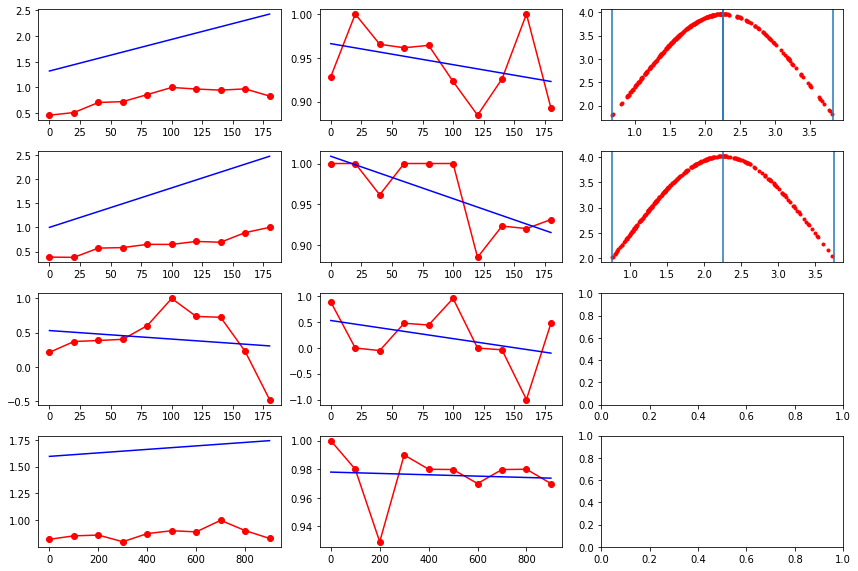

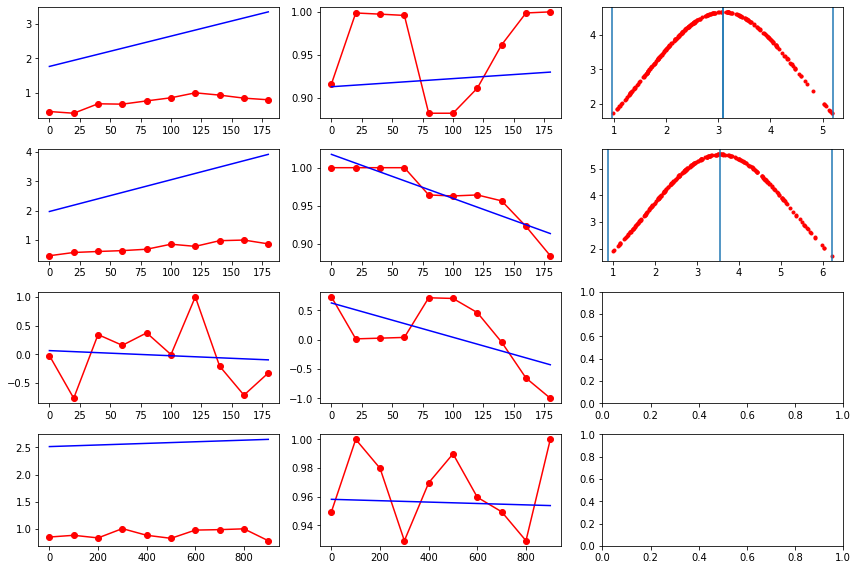

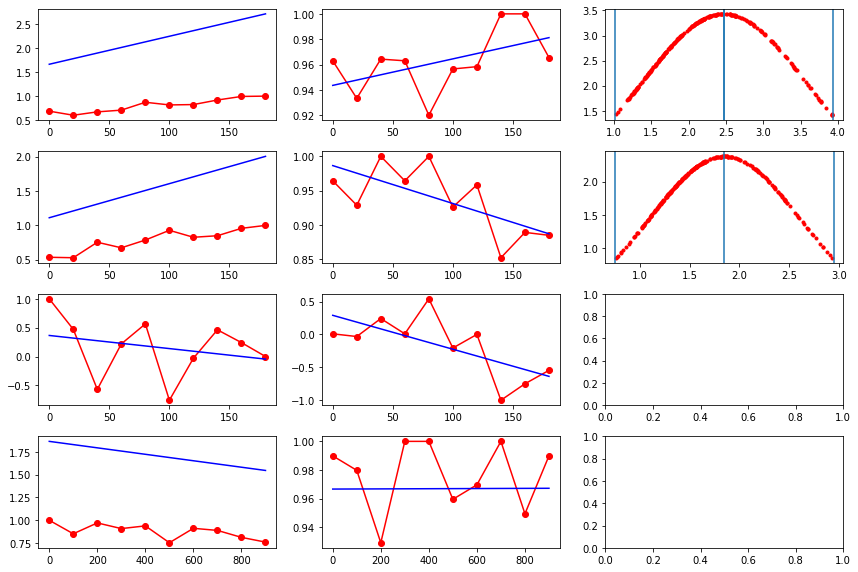

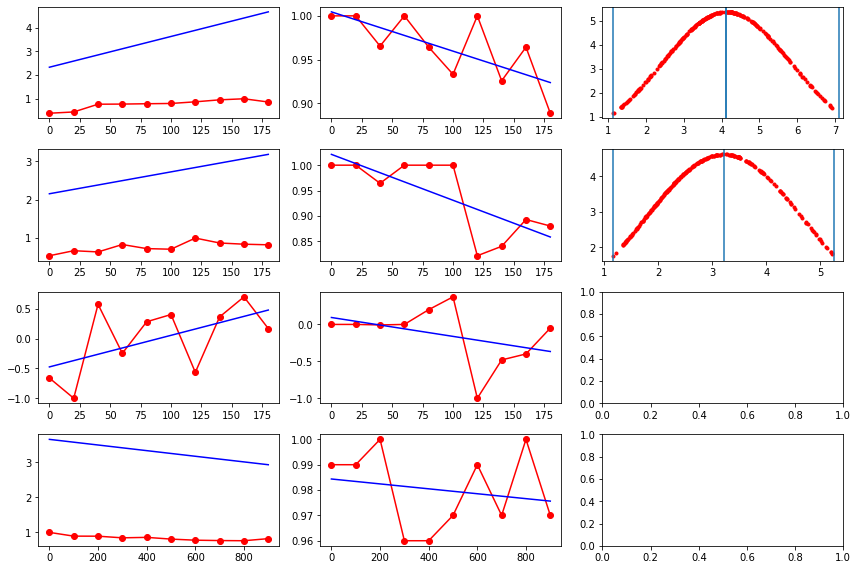

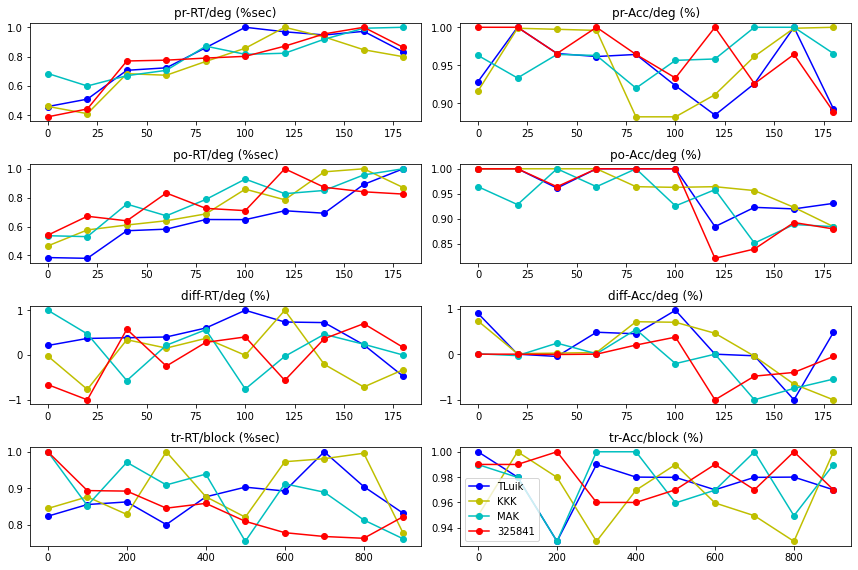

In [ ]:
data1 = MT_Data("TLuik_NAIL_MRT_Type1_2022-11-24_11h18.23.754.csv",includeMirrored0=False,plot=True)
data2 = MT_Data("KKK_NAIL_MRT_Type1_2022-12-01_13h23.41.620.csv",includeMirrored0=False, plot=True)
data3 = MT_Data("MAK_NAIL_MRT_Type1_2022-11-16_11h12.44.950.csv",includeMirrored0=False,plot=True)
data4 = MT_Data("325841_NAIL_MRT_Type1_2022-11-16_14h48.46.293.csv",includeMirrored0=False,plot=True)
getMergedData([data1,data2,data3,data4])
#data2.plot()
print("-------------------------------------------------------------")

#data2.plot()
